In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import graph_tool.all as gt
import sys
sys.path.append('/Users/glover.co/Documents/laszlo/NetDesign/scripts')
import assembly_tree as at
sys.path.append('/Users/glover.co/Documents/laszlo/NetDesign/scripts')
import mcmc
import treelib
from itertools import product
import time

In [2]:
X = np.vstack([np.eye(3) for i in range(2)])
O = np.array([[0,1,1],[1,0,1],[1,1,2]])
capacity = O.sum(axis=1,dtype=int)
target = nx.Graph()
target.add_nodes_from(np.arange(6))
target.add_edges_from([[0,1],[1,2],[2,0],[3,4],[4,5],[5,3],[2,5]])
                    #    [6,7],[7,8],[8,6],[9,10],[10,11],[11,9],[2,5]])
                    #    [12,13],[13,14],[14,12],[15,16],[16,17],[17,15],
                    #    [2,5],[5,8],[8,11],[11,14],[14,17],[17,2]])

In [16]:
X = np.loadtxt('../data/protein_complex/proteins/human/Xfiles/X_CPX-1919.txt')
target_edges = np.loadtxt('../data/protein_complex/proteins/human/edgefiles/CPX-1919.edge', dtype=int)
target = nx.from_edgelist(target_edges)
O = at.extract_O(target,X)
capacity = at.extract_deg_cap(target,X).reshape(-1)

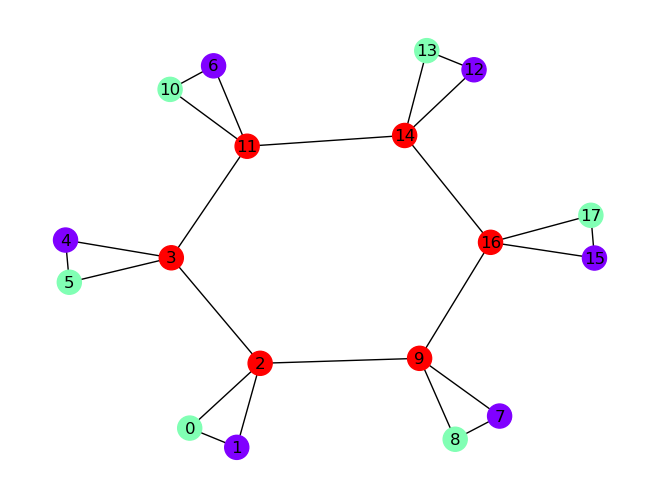

In [9]:
# new_g = at.microcanonical_ensemble(X,O,capacity)
# new_g = at.microcanonical_ensemble(X,O,capacity)
at.draw_network(target,X,with_labels=True)


In [12]:
start = time.time()
new_g = at.microcanonical_ensemble(X,O,capacity)
graphs = [new_g.copy()]
counts = [1]
for i in range(1000):
    found = False
    at.rewire(new_g,X,O,1000)
    for g in graphs:
        if nx.is_isomorphic(new_g,g):
            found = True
            counts[graphs.index(g)] += 1
            break
    
    if found is False:
        graphs.append(new_g.copy())
        counts.append(1)
        # at.draw_network(new_g,X,with_labels=True)
        # print('Found new graph',len(graphs))
end = time.time() - start



In [7]:
prob_dist_time = time.time()
initial_graph = nx.Graph()
initial_graph.add_nodes_from(np.arange(X.shape[0]))
p, samples, idx = at.prob_dist(X,O,capacity,max_edges=True,initial_graph = initial_graph,T=1000,max_iters=1000,rewire_est=True)
prob_end = time.time() - prob_dist_time

array([2., 2., 4.])

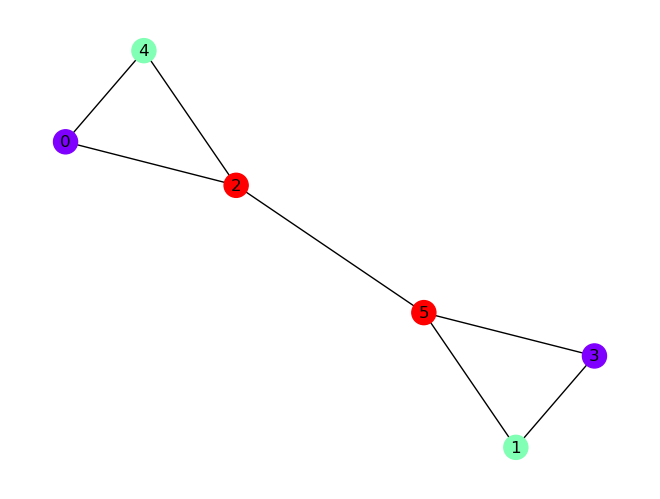

In [4]:
at.draw_network(at.rewire(target,X,O,1000,[(0,4),(0,2),(4,2)]),X,with_labels=True)

In [30]:

ex0 = mcmc.AssemblyTree(target, X, O, capacity)
ex0.update_tree()
ex0.Tree.show()

0
├── 1
├── 2
├── 3
├── 4
├── 5
├── 6
├── 7
├── 8
├── 9
├── 10
└── 11



In [31]:
ex0.Tree.to_dict(with_data=True)

{0: {'children': [{np.int64(1): {'data': <mcmc.AssemblyNode at 0x322afdfd0>}},
   {np.int64(2): {'data': <mcmc.AssemblyNode at 0x315378950>}},
   {np.int64(3): {'data': <mcmc.AssemblyNode at 0x322afd6d0>}},
   {np.int64(4): {'data': <mcmc.AssemblyNode at 0x322afcdd0>}},
   {np.int64(5): {'data': <mcmc.AssemblyNode at 0x322afc4d0>}},
   {np.int64(6): {'data': <mcmc.AssemblyNode at 0x322afe6d0>}},
   {np.int64(7): {'data': <mcmc.AssemblyNode at 0x322afe3d0>}},
   {np.int64(8): {'data': <mcmc.AssemblyNode at 0x322afe1d0>}},
   {np.int64(9): {'data': <mcmc.AssemblyNode at 0x322afd3d0>}},
   {np.int64(10): {'data': <mcmc.AssemblyNode at 0x322afcad0>}},
   {np.int64(11): {'data': <mcmc.AssemblyNode at 0x322afe050>}}],
  'data': <mcmc.AssemblyNode at 0x3157046d0>}}

In [32]:
ex_tree = ex0.Tree.to_dict(with_data=True)
mcmc.expand_tree(ex_tree)

In [33]:
ex_tree

{0: {'children': [{np.int64(1): {'data': [0, 5, 12, 14, 16, 17]}},
   {np.int64(2): {'data': [6, 8]}},
   {np.int64(3): {'data': [9, 10]}},
   {np.int64(4): {'data': [3]}},
   {np.int64(5): {'data': [7]}},
   {np.int64(6): {'data': [4]}},
   {np.int64(7): {'data': [15]}},
   {np.int64(8): {'data': [13]}},
   {np.int64(9): {'data': [11]}},
   {np.int64(10): {'data': [2]}},
   {np.int64(11): {'data': [1]}}],
  'data': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]}}

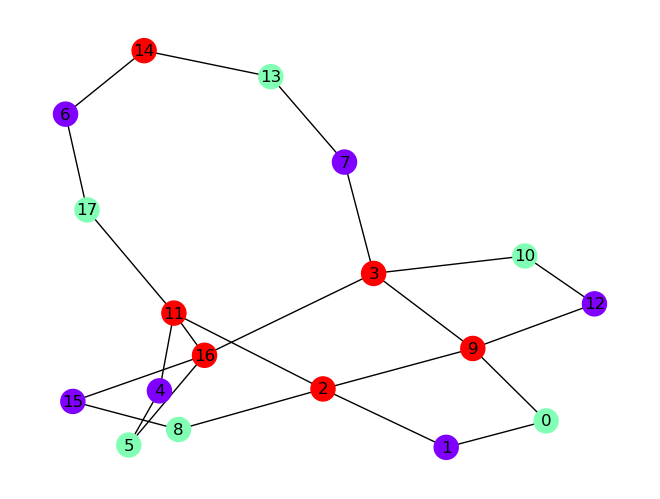

In [18]:
at.draw_network(ex0.Tree.get_node(0).data.subgraph[0],X,with_labels=True)

In [20]:
sum(ex0.Tree.get_node(0).data.p)

0

In [21]:
mcmc_attempt0 = mcmc.DesignMCMC(ex0)

/Users/glover.co/Documents/laszlo/NetDesign/scripts/mcmc.py:414: RuntimeWarning: divide by zero encountered in log
  self.cur_prob = copy.deepcopy(np.log(sum(self.cur_T.Tree.get_node(0).data.p)))


In [9]:
ex0.Tree.show()

0
├── 1
├── 2
└── 3



In [23]:
mcmc_attempt0.run_mcmc(1000, verbose=True)

100%|██████████| 1000/1000 [29:06<00:00,  1.75s/it] 


In [10]:
unique_samples = []
log_prob = []
count = []
for i, s in enumerate(mcmc_attempt0.samples):
    tree = s.Tree.to_dict(with_data=True)
    mcmc.expand_tree(tree)
    new = True
    for j, k in enumerate(unique_samples):
        if k == s:
            count[k] += 1
            log_prob[k] += mcmc_attempt0.log_p[i]
            new = False
            break
    if new:
        unique_samples.append(tree)
        count.append(1)
        log_prob.append(mcmc_attempt0.log_p[i])
log_prob = np.array(log_prob)
count = np.array(count)
log_prob /= count

In [10]:

dist = mcmc_attempt0.log_p / sum(mcmc_attempt0.log_p)

/var/folders/8t/4z1vq2xd5790h0y5jrvphttr0000gp/T/ipykernel_1591/1002972025.py:1: RuntimeWarning: divide by zero encountered in log
  plt.plot(mcmc_attempt0.log_p,[np.log(sum(s.Tree.get_node(0).data.p)) for s in mcmc_attempt0.samples],'o',alpha=.5)


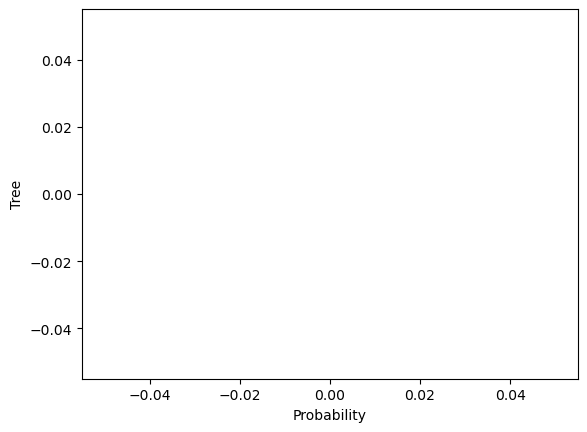

In [24]:
plt.plot(mcmc_attempt0.log_p,[np.log(sum(s.Tree.get_node(0).data.p)) for s in mcmc_attempt0.samples],'o',alpha=.5)
plt.xlabel('Probability')
plt.ylabel('Tree')
plt.show()

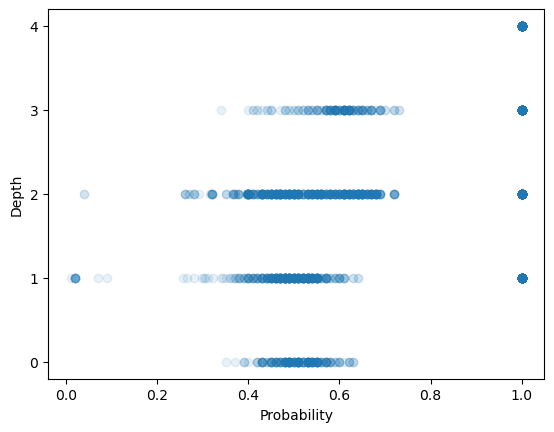

In [25]:
plt.plot(np.exp(mcmc_attempt0.log_p),[s.Tree.depth() for s in mcmc_attempt0.samples],'o',alpha=.1)
plt.ylabel('Depth')
plt.yticks([0,1,2,3,4],[0,1,2,3,4])
plt.xlabel('Probability')
plt.show()
# count = 0
# for i,s in enumerate(mcmc_attempt0.samples):
#     if np.log(sum(s.Tree.get_node(0).data.p)) != mcmc_attempt0.log_p[i]:
#         count += 1
# print(count)

In [25]:
x = np.array([1,2,3])
x.astype(str)

array(['1', '2', '3'], dtype='<U21')

In [14]:
mcmc_attempt0.samples[589].Tree.show()

0
├── 1
│   ├── 3
│   │   ├── 5
│   │   └── 6
│   └── 4
└── 2



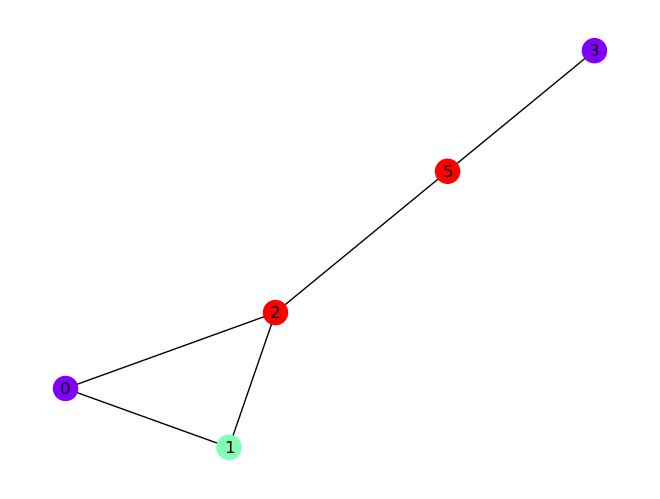

In [15]:
at.draw_network(mcmc_attempt0.samples[589].Tree.get_node(1).data.subgraph[0],X,with_labels=True)

Text(0.5, 1.0, '(np.float64(1.0), np.int64(589))')

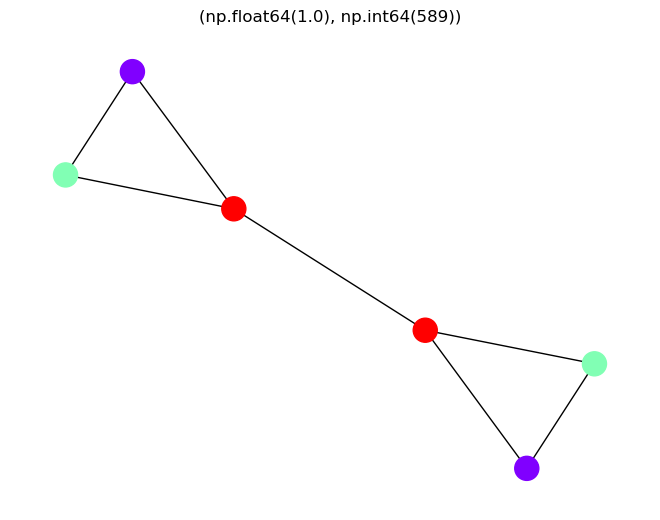

In [13]:
at.draw_network(mcmc_attempt0.samples[np.argsort(mcmc_attempt0.log_p)[-1]].Tree.get_node(0).data.subgraph[0],X)
plt.title((sum(mcmc_attempt0.samples[np.argsort(mcmc_attempt0.log_p)[-1]].Tree.get_node(0).data.p),np.argsort(mcmc_attempt0.log_p)[-1]))

In [ ]:
unique_dicts = []
tree_dict = mcmc_attempt0.samples[-1].Tree.to_dict(with_data=True)
expand_tree(tree_dict)
unique_dicts.append(tree_dict)


In [ ]:
tree_dict in unique_dicts

In [62]:
def expand_tree(tree_dict):
    stack = [tree_dict]
    while stack:
        current = stack.pop()
        for node_id, node in current.items():
            if 'data' in node:
                node['data'] = np.sort(node['data'].nodes)
            if 'children' in node:
                stack.extend(node['children'])

In [ ]:
A = nx.adjacency_matrix(test, nodelist=test.nodes(), weight='weight').todense()
(X[test.nodes()]@O - A@X[test.nodes()])@X[test.nodes()].T, test.nodes()

In [22]:
new_g = at.microcanonical_ensemble(X,O,capacity,initial_graph=test.copy())

In [ ]:
at.draw_network(new_g,X,with_labels=True)

In [ ]:
at.draw_network(test,X, with_labels=True)

In [ ]:
A = nx.adjacency_matrix(test).todense()

X[list(test.nodes())]@O - A@X[list(test.nodes())]

In [ ]:
ex0.Tree.show()

In [ ]:
at.draw_network(ex0.Tree.get_node(1).data.subgraph[0],ex0.X,with_labels=True)
plt.title(ex0.Tree.get_node(1).data.p)

In [ ]:
at.draw_network(ex0.Tree.get_node(3).data.subgraph[0],ex0.X)

In [24]:
ex0.update_prob(0)

In [ ]:
at.draw_network(ex0.Tree.get_node(0).data.subgraph[2],ex0.X)

In [ ]:
initial_graph = nx.Graph()
initial_graph.add_nodes_from([0,1,2,5])
initial_graph.add_edges_from([[0,1],[2,5]])
p, samples, idx = at.prob_dist(ex0.X,ex0.O,ex0.capacity,initial_graph=initial_graph,max_edges=True,labeled=False)
at.draw_network(samples[1],ex0.X,with_labels=True)

In [ ]:
p

In [ ]:
at.draw_network(ex0.Tree.get_node(0).data.subgraph[0],ex0.X,with_labels=True)

In [ ]:
at.draw_network(ex0.Tree.get_node(2).data.subgraph[1],ex0.X)

In [ ]:
at.draw_network(ex0.Tree.get_node(2).data.subgraph[0],ex0.X)

In [ ]:
sum(ex0.Tree.get_node(0).data.p)

In [ ]:
sub_nodes

In [ ]:
g = nx.Graph()
g.add_nodes_from(np.arange(6))
p, samples, idx = at.prob_dist(X,O,capacity,initial_graph=g,max_edges=True,labeled=False,max_iters=100)

In [ ]:
true_A = ex0.target_A[:,sub_nodes][sub_nodes,:]
cur_a = nx.adjacency_matrix(samples[0]).todense()
np.allclose(true_A,cur_a)

In [ ]:
at.draw_network(samples[3],X,with_labels=True)

In [ ]:
p

In [ ]:
children = ex0.Tree.get_node(0).successors(ex0.Tree.identifier)

In [56]:
zero_prob = np.prod(np.array([np.prod(x) for c in children for x in ex0.Tree.get_node(c).data.logP ]))

In [63]:
subgraph_list = [ex0.Tree.get_node(c).data.subgraph for c in children]

In [ ]:
subgraph_list

In [9]:
x = 1
y = 2
z = 3
true_list = [x,y,z]
for j, s in enumerate(true_list):
    true_list[j] = 4

In [70]:
list1 = [1,2,3,4,5,6]
list2 = [4,5,6,7]
list3 = [2,1]

In [71]:
from itertools import product

In [ ]:
np.prod(list(product(list1, list2, list3)),axis=1)

In [ ]:
bowtie = nx.Graph()
bowtie.add_nodes_from(np.arange(6))
# bowtie.add_edges_from([[0,1],[1,2],[2,0],[3,4],[4,5],[5,3],[2,5]])
bowtie.add_edges_from([[0,1],[4,2],[2,5],[5,1],[3,4],[5,3],[2,0]])
at.draw_network(bowtie,X,with_labels=True)

In [64]:
subgraph = nx.Graph()
subgraph.add_nodes_from([0,1,2,3])
subgraph.add_edges_from([[0,1],[1,2],[2,3],[3,0]])

In [66]:
iso = nx.isomorphism.GraphMatcher(bowtie, subgraph)

In [ ]:
iso.subgraph_is_isomorphic()

In [37]:
import json
with open('../data/classA.json', 'r') as f:
    classA = json.load(f)

In [38]:
classA['molecules']

[['molecules', 'WHO', 'CID_10112'],
 ['molecules', 'WHO', 'CID_11029'],
 ['molecules', 'WHO', 'CID_11248'],
 ['molecules', 'WHO', 'CID_119432'],
 ['molecules', 'WHO', 'CID_165565'],
 ['molecules', 'WHO', 'CID_168924'],
 ['molecules', 'WHO', 'CID_17358'],
 ['molecules', 'WHO', 'CID_23665760'],
 ['molecules', 'WHO', 'CID_23668193'],
 ['molecules', 'WHO', 'CID_23668197'],
 ['molecules', 'WHO', 'CID_24083'],
 ['molecules', 'WHO', 'CID_24243'],
 ['molecules', 'WHO', 'CID_24266'],
 ['molecules', 'WHO', 'CID_24393'],
 ['molecules', 'WHO', 'CID_24424'],
 ['molecules', 'WHO', 'CID_24436'],
 ['molecules', 'WHO', 'CID_24439'],
 ['molecules', 'WHO', 'CID_24456'],
 ['molecules', 'WHO', 'CID_24462'],
 ['molecules', 'WHO', 'CID_24470'],
 ['molecules', 'WHO', 'CID_24934'],
 ['molecules', 'WHO', 'CID_25960'],
 ['molecules', 'WHO', 'CID_280'],
 ['molecules', 'WHO', 'CID_3032553'],
 ['molecules', 'WHO', 'CID_4101'],
 ['molecules', 'WHO', 'CID_445709'],
 ['molecules', 'WHO', 'CID_516900'],
 ['molecules', 